Quick and dirty visualizer based on Lauren's code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

Here is a scheme from [this link](http://sweetme.at/2013/10/21/how-to-detect-python-2-vs-3-in-your-python-script/) that imports `urllib2` properly depending on the Python version.

In [2]:
import sys
if (sys.version_info > (3, 0)):
    import urllib.request as urllib2
else:
    import urllib2

For the given URLs of the calibrator (usually 3C48 or 3C295) and the maser target, the text files from the are stored as local strings.

In [3]:
cal_URL = 'http://www.gb.nrao.edu/20m/peak/3C48-028/Skynet_57670_3C48-028_24454_24482.A.spect.cal.txt';
cal_response = urllib2.urlopen(cal_URL);

target_URL = 'http://www.gb.nrao.edu/20m/peak/W3-028/Skynet_57639_W3-028_23774_23815.A.spect.cal.txt';
target_response = urllib2.urlopen(target_URL);

The web strings are loaded like text files. After skipping the header rows, the remaining columns of numbers are loaded into numpy arrays. The preceding outputs can only be called once lest the buffer read get stuck at the end, it seems. So, below is a single call to make a six-column array which is then sliced into the two IFs. Furthremore, these different arrays could easily be a single array with numerous columns, but are separate here for transparency of processing.

In [4]:
cal = np.loadtxt(cal_response, skiprows = 45, usecols = (0,1,2,3,4,5));
cal_IF1 = cal[:,0:3]; # 'slicing' starts with index 0 and ends with index 3-1 apparently
cal_IF2 = cal[:,3:]; # end limit blank means all the way to the end (not end-1) apparently
target = np.loadtxt(target_response, skiprows = 45, usecols = (0,1,2,3,4,5));
target_IF1 = target[:,0:3];
target_IF2 = target[:,3:];

Plot up a quick look at the different IFs and polarizations.

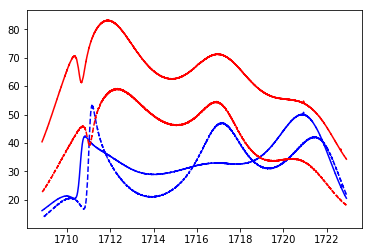

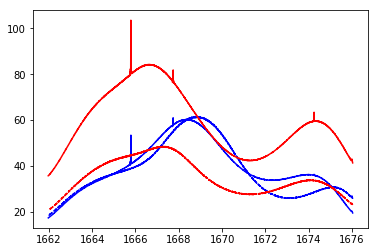

In [5]:
plt.figure(1)
plt.plot(cal_IF1[:,0], cal_IF1[:,1], 'b--')
plt.plot(target_IF1[:,0], target_IF1[:,1], 'b-')
plt.plot(cal_IF1[:,0], cal_IF1[:,2], 'r--')
plt.plot(target_IF1[:,0], target_IF1[:,2], 'r-')
plt.show()
plt.figure(2)
plt.plot(cal_IF2[:,0], cal_IF2[:,1], 'b--')
plt.plot(target_IF2[:,0], target_IF2[:,1], 'b-')
plt.plot(cal_IF2[:,0], cal_IF2[:,2], 'r--')
plt.plot(target_IF2[:,0], target_IF2[:,2], 'r-')
plt.show() 

Without calibrating the bandpass, attempt a polynomial baseline fit in order to flatten the spectrum and retrieve some instructive stats. Arbitrarily choose ninth order polynomial. User inputs the limits of the fit as channel numbers.

In [6]:
# number of channels
len( cal_IF2[:,0] )

7373

In [7]:
chmin = 2000;
chmax = 3000;

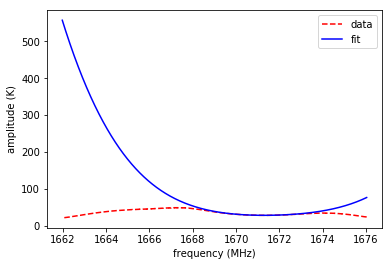

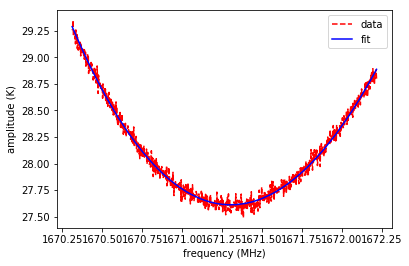

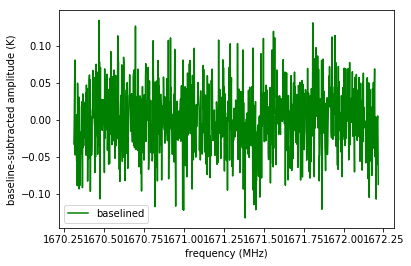

In [8]:
def baseline(x, a9,a8,a7,a6,a5,a4,a3,a2,a1,a0):
    return a9*x*x*x*x*x*x*x*x*x+a8*x*x*x*x*x*x*x*x+a7*x*x*x*x*x*x*x+a6*x*x*x*x*x*x+a5*x*x*x*x*x+a4*x*x*x*x+a3*x*x*x+a2*x*x+a1*x+a0

popt, pcov = curve_fit(baseline, cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2], bounds=([-2,-2,-10,-10,-10,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf],[2,2,10,10,10,np.inf,np.inf,np.inf,np.inf,np.inf]));

plt.figure();
plt.plot(cal_IF2[:,0], cal_IF2[:,2], 'r--', label='data')
plt.plot(cal_IF2[:,0], baseline(cal_IF2[:,0], *popt), 'b-', label='fit')
plt.xlabel('frequency (MHz)')
plt.ylabel('amplitude (K)')
plt.legend()
plt.show()
plt.figure();
plt.plot(cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2], 'r--', label='data')
plt.plot(cal_IF2[chmin:chmax,0], baseline(cal_IF2[chmin:chmax,0], *popt), 'b-', label='fit')
plt.xlabel('frequency (MHz)')
plt.ylabel('amplitude (K)')
plt.legend()
plt.show()
plt.figure();
plt.plot(cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt), 'g-', label='baselined')
plt.xlabel('frequency (MHz)')
plt.ylabel('baseline-subtracted amplitude (K)')
plt.legend()
plt.show()

The root&ndash;mean&ndash;square of the flattened spectrum is given below.

In [9]:
rms = np.sqrt( np.mean( (cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt))*(cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt)) ) );
rms

0.043173734101998297

Alternatively, we may assemble bandpass-calibrated spectra. These are not normalized, merely flattened (as best we can). We should be dividing the cal spectrum by CH0 before using it.

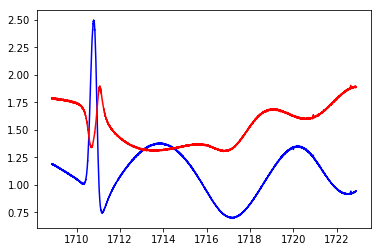

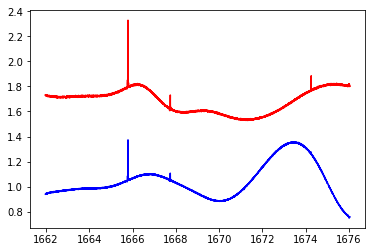

In [10]:
bpass_IF1 = np.transpose( np.array( [ target_IF1[:,0] , np.divide(target_IF1[:,1],cal_IF1[:,1]) ,  np.divide(target_IF1[:,2],cal_IF1[:,2]) ] ) );
bpass_IF2 = np.transpose( np.array( [ target_IF2[:,0] , np.divide(target_IF2[:,1],cal_IF2[:,1]) ,  np.divide(target_IF2[:,2],cal_IF2[:,2]) ] ) );
plt.figure()
plt.plot(bpass_IF1[:,0], bpass_IF1[:,1], 'b-')
plt.plot(bpass_IF1[:,0], bpass_IF1[:,2], 'r-')
plt.figure()
plt.plot(bpass_IF2[:,0], bpass_IF2[:,1], 'b-')
plt.plot(bpass_IF2[:,0], bpass_IF2[:,2], 'r-')
plt.show()

If the above spectra had flat baselines, we could easily assess the rms...that is the next effort.

Some zoomed-in views of a few maser lines in the raw data.

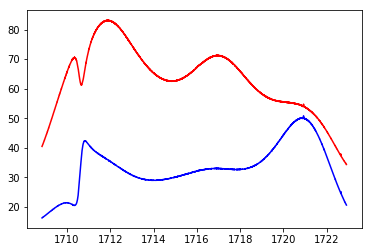

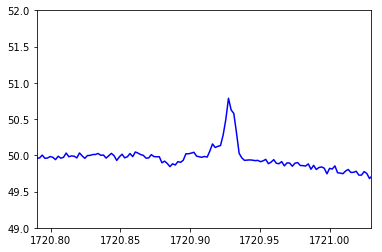

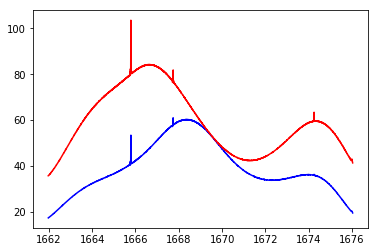

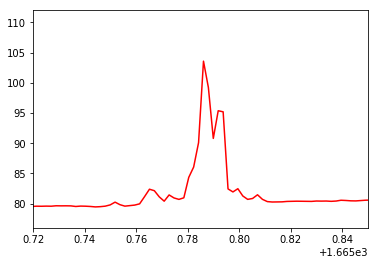

In [11]:
plt.figure(3)
plt.plot(target_IF1[:,0], target_IF1[:,1], 'b-')
plt.plot(target_IF1[:,0], target_IF1[:,2], 'r-')
plt.show()
plt.figure(4)
plt.plot(target_IF1[:,0], target_IF1[:,1], 'b-')
plt.xlim( [1720.790, 1721.030] );
plt.ylim( [49.0, 52.0] );
plt.show()
plt.figure(5)
plt.plot(target_IF2[:,0], target_IF2[:,1], 'b-')
plt.plot(target_IF2[:,0], target_IF2[:,2], 'r-')
plt.show()
plt.figure(6)
plt.plot(target_IF2[:,0], target_IF2[:,2], 'r-')
plt.xlim( [1665.720, 1665.850] );
plt.ylim( [76.0, 112.0] );
plt.show()